In [1]:
import numpy as np
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
# randomly initializing theta parameters

def randomInitializeWeights(L_in,L_out):
    W=np.zeros((L_out,L_in+1))
    epsilon = 0.12
    W = np.random.rand(L_out,L_in+1)*(2*epsilon)-epsilon
    return W   

In [3]:
def sigmoid(z):  
    return 1 / (1 + np.exp(-z))

In [4]:
def sigmoid_gradient(z):  
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

In [5]:
# feedforward propagation

def forward_propagate(X, theta1, theta2):  
    
    m = X.shape[0]

    a1 = np.insert(X, 0, values=np.ones(m), axis=1)   # input layer activation
    z2 = a1 * theta1.T     
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(m), axis=1)  # hidden layer activation 
    z3 = a2 * theta2.T
    h = sigmoid(z3)    # output layer activation

    return a1, z2, a2, z3, h
    

In [6]:
# Function to find the cost

def cost(params, input_size, hidden_size, num_labels, X, y, learning_rate):  
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)

    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)

    # compute the cost
    J = 0
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)

    J = J *1.0/ m
    
    # adding the regulariztion term 
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))  
    
    return J

In [7]:
# error backpropagation function (returns cost and gradient of the cost)

def backprop(params, input_size, hidden_size, num_labels, X, y, learning_rate):  
    
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)

    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)

    # initializations
    J = 0
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)

    # compute the cost
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)

    J = J / m

    # add the cost regularization term
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))

    ##### end of cost function logic, below is the new part #####

    # perform backpropagation
    for t in range(m):
        a1t = a1[t,:]  
        z2t = z2[t,:]  
        a2t = a2[t,:]  
        ht = h[t,:]  
        yt = y[t,:]  

        d3t = ht - yt  

        z2t = np.insert(z2t, 0, values=np.ones(1))  
        d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_gradient(z2t))  
        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + d3t.T * a2t

    delta1 = delta1 / m
    delta2 = delta2 / m

    # add the gradient regularization term
    delta1[:,1:] = delta1[:,1:] + (theta1[:,1:] * learning_rate) / m
    delta2[:,1:] = delta2[:,1:] + (theta2[:,1:] * learning_rate) / m

    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))

    return J, grad

Cross Validation accuracy for learning rate 0.1 is 92.00%
Cross Validation accuracy for learning rate 0.3 is 92.90%
Cross Validation accuracy for learning rate 1 is 93.90%
Cross Validation accuracy for learning rate 3 is 92.50%
Cross Validation accuracy for learning rate 9 is 92.00%

Best Accuracy achieved by Cross Validation data set is 93.90% for learning rate 1

Time taken to Run loop and find the best weight paramters is 1269.440 s

Time taken to learn the weight parameters 1268.846 s

Time taken to make prediction 0.594 s


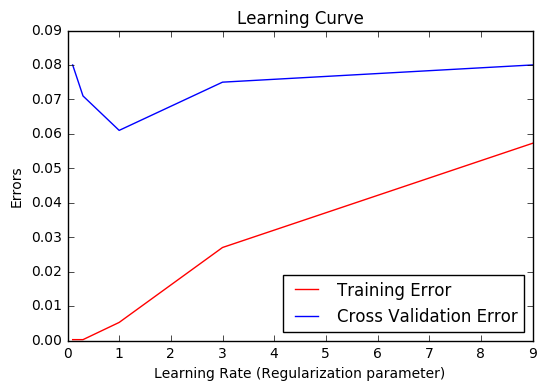

In [9]:
# Loading the parameters

mat_contents = sio.loadmat('ex4dataN.mat')
X = np.matrix(mat_contents['X'])
y = np.matrix(mat_contents['y'])

# splitting the data into training and cross validation sets
X_train, X_CV, y_train, y_CV = train_test_split(X, y, test_size=0.2, random_state=0)

# Endoing labels Y such that each label is a vector with 1 at index 'label' and zero otherwise
encoder = OneHotEncoder(sparse=False)  
y_train_onehot = encoder.fit_transform(y_train)

# input layer size (equal to number of features (X.shape[1]))
input_size = 400  

# hidden layer size selected randomaly 
hidden_size = 25  

# output layer size equal to the y_onehot.shape[1] (because labels are between [0,9]) 
num_labels = 10  

# randomly initialize a parameter array of the size of the full network's parameters
params = (np.random.random(size=hidden_size * (input_size + 1) + num_labels * (hidden_size + 1)) - 0.5) * 0.25

# number of training examples
m = X_train.shape[0]  

# unravel the parameter array into parameter matrices for each layer
theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))  
theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

# initialize the accuracy
best_accuracy = 0

# minimize the objective function
learning_rate = [0.1,0.3,1,3,9]
error_train = []
error_CV = []

'''
run the loop for all the values of learning rate. This will help us determine the learning rate parameter for 
which cross validation accuracy is highest, we can also plot the learning rate curve
'''

time_loop = []
time_loop_start = time.time()

for l in learning_rate:
    
    time_start = time.time()
    
    # using advanced optimization technique 'TNC' to find the weigths 'theta'
    fmin = minimize(fun=backprop, x0=params, args=(input_size, hidden_size, num_labels, X_train, y_train_onehot, l),  
                method='TNC', jac=True, options={'maxiter': 250})
    
    time_end = time.time()
    
    time_loop.append(time_end-time_start)
    
    # weights for the input layer
    theta1 = np.matrix(np.reshape(fmin.x[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    
    #weights for the output layer
    theta2 = np.matrix(np.reshape(fmin.x[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    # activation values of all the neural network layers for cross validation and training datasets
    a1_CV, z2_CV, a2_CV, z3_CV, h_CV = forward_propagate(X_CV, theta1, theta2)
    a1_train, z2_train, a2_train, z3_train, h_train = forward_propagate(X_train, theta1, theta2)
    
    # predicting the label values for cross validation and training data sets
    # prediction output will be the output layer unit for which the activation is maximum
    
    yCV_pred =  np.array(np.argmax(h_CV, axis=1) )
    ytrain_pred = np.array(np.argmax(h_train,axis=1))
    
    # Finding the cross validation accuracy
    correctCV = [1 if a == b else 0 for (a, b) in zip(yCV_pred, y_CV)]  
    accuracyCV = (sum(map(int, correctCV)) / float(len(correctCV))) 
    
    # Finding the cross validation error
    IncorrectCV = [1 if a != b else 0 for (a, b) in zip(yCV_pred, y_CV)]  
    errorCV = (sum(map(int, IncorrectCV)) / float(len(IncorrectCV)))
    error_CV.append(errorCV)
    
    # Finding the training accuracy
    correcttrain = [1 if a == b else 0 for (a, b) in zip(ytrain_pred, y_train)]  
    accuracytrain = (sum(map(int, correcttrain)) / float(len(correcttrain))) 
    
    # Finding the training error
    Incorrecttrain = [1 if a != b else 0 for (a, b) in zip(ytrain_pred, y_train)]  
    errortrain = (sum(map(int, Incorrecttrain)) / float(len(Incorrecttrain)))
    error_train.append(errortrain)
    
    if accuracyCV>best_accuracy:
        best_accuracy = accuracyCV
        best_learningrate = l
        final_theta1 = theta1
        final_theta2 = theta2
    print("Cross Validation accuracy for learning rate {} is {:.2f}%".format(l, accuracyCV*100))

print("\nBest Accuracy achieved by Cross Validation data set is {:.2f}% for learning rate {}".format(best_accuracy*100,best_learningrate))

time_loop_end = time.time()

time_opt = time_loop_end-time_loop_start

print("\nTime taken to Run loop and find the best weight paramters is {:.3f} s".format(time_opt))
print("\nTime taken to learn the weight parameters {:.3f} s".format(sum(time_loop)))
print("\nTime taken to make prediction {:.3f} s".format(time_opt-sum(time_loop)))

    
# Plotting the Learning Curves for training and cross validation error with learning_rates

plt.plot(learning_rate,error_train,'r',label = 'Training Error')
plt.plot(learning_rate, error_CV, 'b', label = 'Cross Validation Error')
plt.legend(loc='best')

plt.title('Learning Curve')
plt.xlabel('Learning Rate (Regularization parameter)')
plt.ylabel('Errors')